## Learning Audio Components using SVD

SVD decomposes the data matrix X into 3 matrices $$\mathbf{X} = \mathbf{U}\mathbf{D}\mathbf{V^T}$$

**D** is a diagonal matrix. Each element **D[i,i]** is fraction of the overall standard deviation in the data due to contribution of the element in column i of matrix **U**.

**U** becomes the new coordinate system (basis), and the coordiantes of each data sample in **X** are given by rows of **V**.

This technique is also closely related to sub-space projection methods for denoising.  
Let us create a synthetic sound example comprising of a sinusoid with noise.

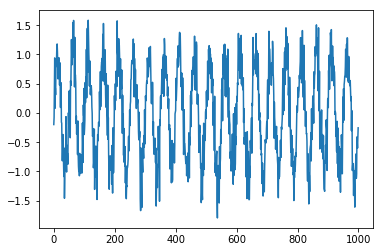

In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fs = 10000
f0 = 200 #220
T = 3
Ns = fs*T
s = np.sin(2*np.pi*f0*np.arange(Ns)/fs)
n = np.random.randn(Ns)
x = s + 0.3*n 

# See Exercise description below
# s2 = sin(2*pi*3.5*f0*arange(Ns)/fs)
# x = s + s2 + 0.3*n

plt.plot(x[:1000])

from scipy.io import wavfile
wavfile.write('out1.wav', fs, x)

As we have already seen, the first step in audio processing is cutting it into separate frames, also known as "audio vectors".

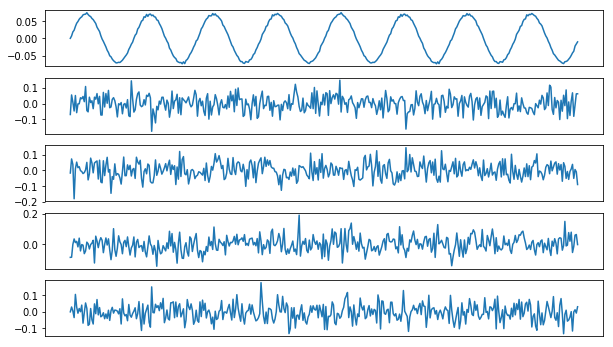

In [19]:
from numpy.linalg import svd

def buffer(input_data, sample_rate, window_size, hop_size):
    output = np.array([input_data[i:i+window_size] for i in range(0, len(input_data)-window_size, hop_size)])
    return output.T


xmat = buffer(x,fs,400,200)
U, D, V = svd(xmat)

plt.figure(figsize=(10, 6))

for i in range(5):
    plt.subplot(5,1,i+1)
    plt.plot(U[:,i])
    plt.xticks([])

The contribution of each of the different factors are as follows

<Container object of 3 artists>

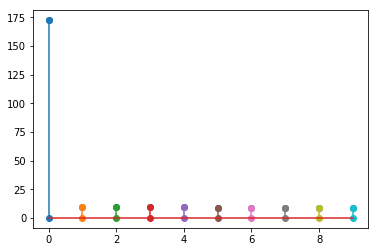

In [20]:
plt.stem(D[:10],'-o')

And here are the coefficients of each component (first 5) 

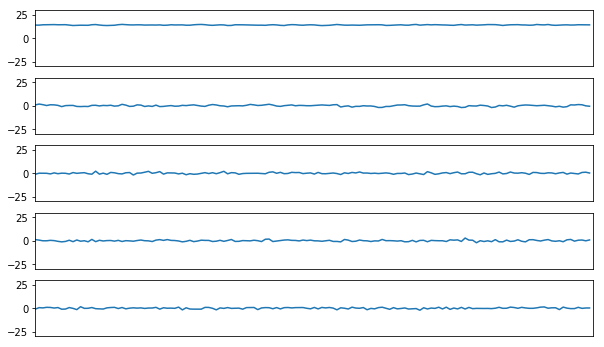

In [21]:
plt.figure(figsize=(10, 6))

for i in range(5):
    plt.subplot(5,1,i+1)
    plt.plot(V[i,:]*D[i])
    plt.axis([0,V.shape[0],-30,30])
    plt.xticks([])


We can also reconstruct the orignal signal using few components

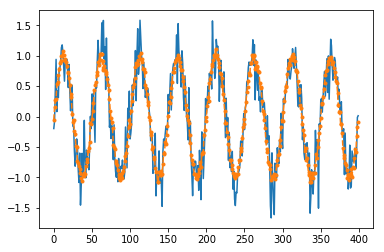

In [22]:
plt.figure()
plt.plot(xmat[:,0])
plt.plot(U[:,0]*D[0]*V[0,0] + U[:,1]*D[1]*V[1,0],'--.')


As you can see, the coefficients of the components change over time, but the first two behave in very periodic manner, while the others are more random.  

How can we measure this predictability? Is it improtant for distinction between structure and noise (especially in time-based signals)?

## Exercise:
In the previous example the period of the sinusoidal component matched exactly the window size of the signal matrix.
* Check how the analysis differs when f0=200 versus 220. 
* Add another component s2 and explain why SVD finds a combination signal. 

In the case when the signal is unknown, the SVD components can be considered as a "sound object" or "audio basis" (versus DFT basis).


## Estimating Structure in Time

The number of features is related to signal complexity. Their predictability is another important feature.

One powerful method is "spectral flatness". Lets do a simple version here

Here we plot rho which is a measure of predictability derived from SFM as 
$$ \rho = e^{-2*\small{SFM}}$$

See: http://en.wikipedia.org/wiki/Spectral_flatness
This measure is closely related to Information Rate, which is a topic of our last lecture


<Container object of 3 artists>

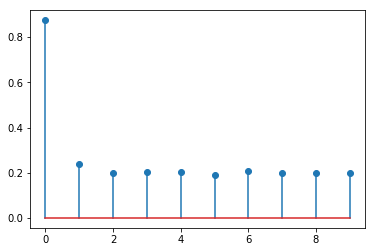

In [29]:
from scipy.stats.mstats import gmean

rho = np.zeros(10)
for i in range(10):
    Vft = abs(np.fft.rfft(V[i,:]))
    sf = gmean(Vft)/np.mean(Vft)
    rho[i] = np.exp(-2*sf)
    
plt.figure()
plt.stem(rho)


### Discussion:

Why this is interesting / useful? Many issues related to perception of structure are based on a balance between complexity and predicability. 

Even our human perception of aesthetics seems to take these relations into account. Complex signals require an effort in terms of the resources needed to decode or represent them efficiently.

Predictability is related to our ability to form expectations and project the future. 
For a full discussion, please see my "Spectral Anticipations" paper in CMJ.


## Audio Basis and Karhunen-Loeve Transform

The decomoposition of our data matrix **X** into three matrices **X** = **UDV** can be also seen as a combination of two matrices: **U** that provides coordinates for a new space where data elements are combined differently and in more efficient way that allows also a lower-dimensional representation, and a set of coefficients **C** = **DV** that give the relative weights of each basis element over time.

Karhunen-Loeve Transform is closely related to PCA and SVD since it also uses eigen-decomposition to represent measurements in a lower dimensional space. Its main distinction is that it operates on random data vectors (patterns with probability function) and performs eigen-vector analysis on the correlation matrix **R**.

Relating this back to SVD is done by noticing that for **X** = **UDV**, the correlation matrix is approximated (up to division by number of frames) by **XX' = UD<sup>2</sup>U'** which has **U** as eigenvector **XX'U = UD<sup>2</sup>**

### Audio Basis
It is common in audio analysis to perform feature extraction not from signal data (samples) directly, but from FFT magnitude. In such case **X** would be a matrix containing the absolute values of Fourier Transform of short audio frames, also known as spectrogram. Thus our measurements or initial patterns are amplitudes of different frequency components, and each frame is considered as a separate experimental outcome. The correlation matrix **R** = E[**XX'**] is approximated by averaging over many such vectos.

Accordngly, **U** are sometimes called Audio Basis Vectors, and their linear combination is given by multiplying them by **V** with their relative "strengths" **D**. The elements of matrix **C** = **DV** are called "time coefficients" or "expension coefficients" for the audio basis **U**.

In [30]:
#svd?

We perform Short Time Fourier Analysis (stft), and use normalized log-spectrum as our features. 

Then we apply SVD to this data matrix. We will reduce the number of elements (basis vectors) which will extract features by retaining fewer vectors with highest eignevalues (elements that contribute most to the variance).

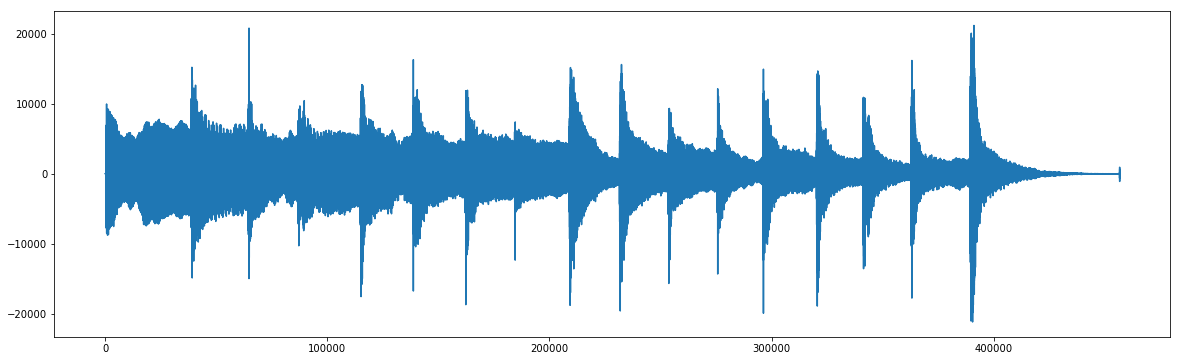

In [43]:
from scipy.io import wavfile
fs, x = wavfile.read('./audio_files/ohm_scale.wav')

from matplotlib import rcParams
plt.rcParams['figure.figsize'] = (20, 6)

plt.plot(x)

(512, 1768) (512,)


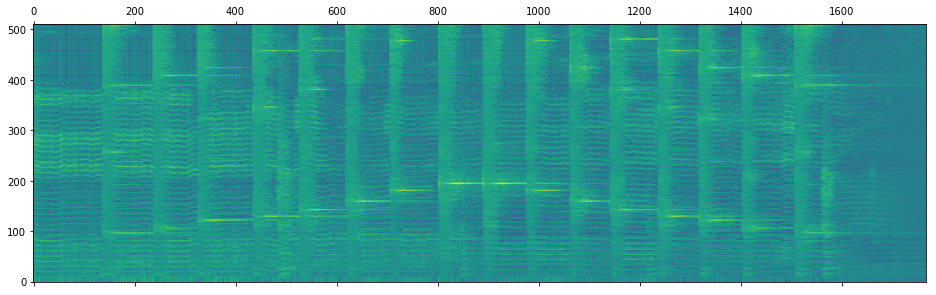

In [44]:
import scipy

def stft(input_data, sample_rate, window_size, hop_size):
    window = scipy.hamming(window_size)
    output = scipy.array([scipy.fft(window*input_data[i:i+window_size]) 
                         for i in range(0, len(input_data)-window_size, hop_size)])
    return output

X = abs(stft(x, fs, 4096, 256)).T
X = np.log(X[:512,:])
Xmean = np.mean(X, axis = 1)
print np.shape(X), np.shape(Xmean)
X = X - np.matrix(Xmean).T*np.matrix(np.ones(np.shape(X)[1]))
X = np.array(X)
D = np.diag(1/np.sqrt(sum(X**2,0))) #
Xnorm = np.dot(X,D)

#imshow(Xnorm,origin='lower')

plt.rcParams['figure.figsize'] = (20, 8)

plt.matshow(Xnorm,origin='lower')

### Computing Correlations

Now when we have our data processed to our satisfaction, we can start computing correlations betwen the rows or the colums of the data matrix.

Let us call **S** the product of rows, or along the time dimension, and **R** the product along columns, or the frequency dimension.

(512, 512)


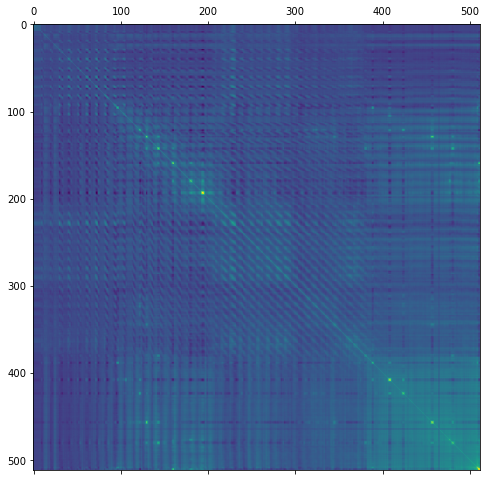

In [48]:
R = np.dot(Xnorm,Xnorm.T)
print R.shape
plt.matshow(R,origin='upper')

(1768, 1768)


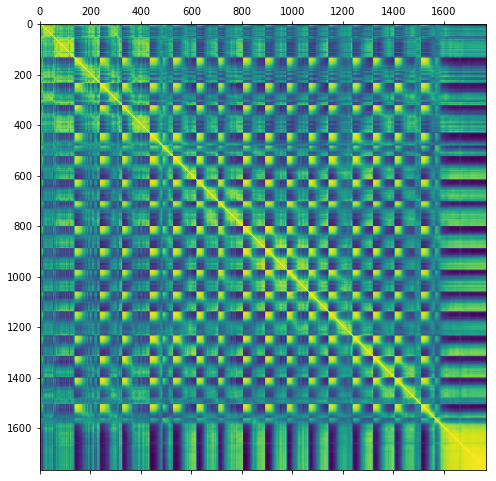

In [49]:
S = np.dot(Xnorm.T,Xnorm)
print S.shape
plt.matshow(S,origin='upper')

Both of these correlation matrices are important for extracting the essential information from our data. Matrix S captures similirities between the spectra across different time. This is easy to understand by visualizing it. Matrix R captures correlations across frequencies, and is harded visualize as such, although we will use its most important dimensions or principal vectors, to reduce the dimension of the data.
Let's first visualize matrix S, which is also known in computer music as "Self Similarity" matrix http://en.wikipedia.org/wiki/Self-similarity_matrix

In [51]:
U, D, V = svd(Xnorm)

U = np.matrix(U)
V = np.matrix(V)
Xnorm = np.matrix(Xnorm)

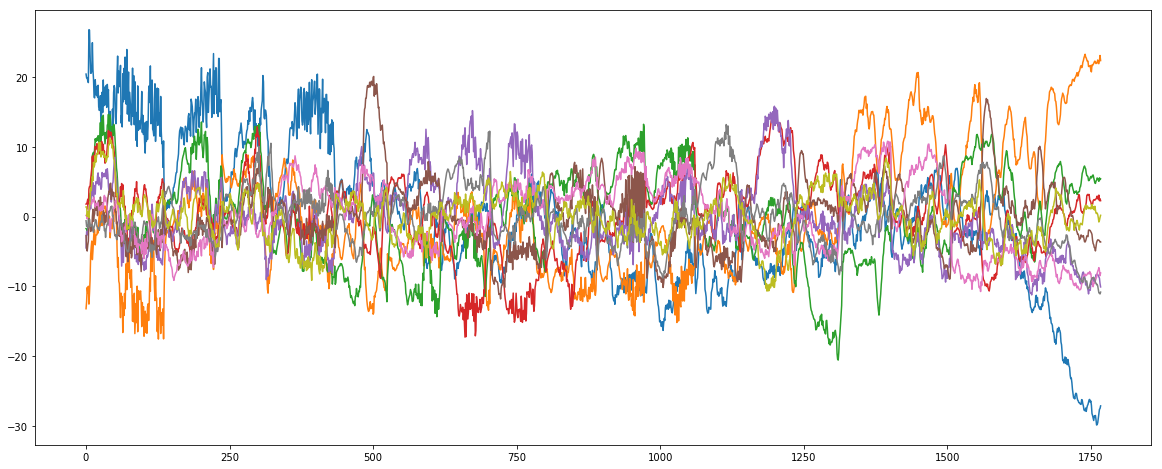

In [54]:
s = 1
dim = 10

#Xdim = U[:,:dim]*diag(D[:dim])*V[:dim,:]
KLT = U[:,s:dim].T * X
Xdim = U[:,s:dim] * KLT

for i in np.arange(0,dim-s):
    plt.plot(np.array(KLT[i,:]).T, label=str(i))
#legend()

#matshow(Xdim,origin='lower', aspect = "auto")

#figure(figsize=(25,25))
#subplot(313)
#imshow(KLT.T*KLT)


## Discussion:
We are lead to expect that KLT would extract the individual notes or components of this recording. Does it do it? Unfortunately not. Some of the reasons are that KLT does not take into account the spectrogram is a positive matrix. There are other methods, such as NMF that are specially designed to do that. Also it is not taking into account the non-linear or non-Gaussian nature of the signals. Methods such as ICA are designed for componenet instruction by taking this information into account. Indeed, Audio Basis is defined as an ICA transform, but in practice many times PCA / KLT are used.